In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import spacy
from yellowbrick.text import FreqDistVisualizer
from pathlib import Path
nlp=spacy.load('en_core_web_sm')
from textblob import TextBlob, Word, Blobber

from sb_utils import save_file


from surprise import accuracy, Dataset, SVD, NormalPredictor, BaselineOnly
from surprise import Reader
from surprise.model_selection import cross_validate, train_test_split, LeaveOneOut, ShuffleSplit 
from surprise.model_selection import RandomizedSearchCV,GridSearchCV
from surprise import KNNBasic,  KNNWithMeans, KNNBaseline
from surprise.model_selection import KFold

from sklearn.model_selection import train_test_split as tts1
import datetime
import math

In [2]:
#full dataset
#wine_df2 = pd.read_csv('C:/Users/jwatki8/Documents/Data Science Program information/Capstone project 3/data/wine_df.csv')

In [2]:
wine_df = pd.read_csv('C:/Users/jwatki8/Documents/Data Science Program information/Capstone project 3/data/wine_df_S.csv')

In [3]:
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 50 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   RatingID                                150000 non-null  int64  
 1   UserID                                  150000 non-null  int64  
 2   WineID                                  150000 non-null  int64  
 3   Vintage                                 150000 non-null  object 
 4   Rating                                  150000 non-null  float64
 5   Date                                    150000 non-null  object 
 6   rating_mean                             150000 non-null  float64
 7   rater_count                             150000 non-null  int64  
 8   rater_mean                              150000 non-null  float64
 9   WineName                                150000 non-null  object 
 10  Type                                    1500

Since our recommender system will be based on user ratings of wine, let’s start by parsing out the user id, wine id and rating.

In [4]:
rec_base=wine_df[['UserID', 'WineID','Rating']]

In [5]:
rec_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   UserID  150000 non-null  int64  
 1   WineID  150000 non-null  int64  
 2   Rating  150000 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 3.4 MB


Next I will create the surprise data set to cross-validate our models on as well as create an anti-set to run predictions on later.

In [6]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(rec_base[['UserID', 'WineID', 'Rating']], reader)
anti_set = data.build_full_trainset().build_anti_testset()

I will start with a Normal Predictor model to examine a baseline RMSE for our dataset.

### Normal Predictor Model

In [7]:
algo = NormalPredictor()
cross_validate(algo, data, measures=["RMSE", "MAE"], cv=3,verbose=True)

Evaluating RMSE, MAE of algorithm NormalPredictor on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9067  0.9016  0.9083  0.9055  0.0029  
MAE (testset)     0.7185  0.7145  0.7208  0.7179  0.0026  
Fit time          0.19    0.21    0.22    0.21    0.01    
Test time         0.64    0.67    0.38    0.56    0.13    


{'test_rmse': array([0.90667394, 0.90156515, 0.90830895]),
 'test_mae': array([0.71845319, 0.71454768, 0.72079583]),
 'fit_time': (0.19170761108398438, 0.21454381942749023, 0.21509575843811035),
 'test_time': (0.6432430744171143, 0.6673738956451416, 0.3750443458557129)}

As expected it looks like our mean RMSE (0.906) is fairly high for a rating scale of 1-5. Let’s try out another model.

### SVD Model

In [8]:
algo2 = SVD()
cross_validate(algo2, data, measures=["RMSE", "MAE"], cv=3,verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.4883  0.4865  0.4906  0.4884  0.0017  
MAE (testset)     0.3594  0.3580  0.3596  0.3590  0.0007  
Fit time          1.64    1.57    1.62    1.61    0.03    
Test time         0.70    0.73    0.42    0.61    0.14    


{'test_rmse': array([0.48825139, 0.48650532, 0.49058397]),
 'test_mae': array([0.35937552, 0.35795554, 0.35956568]),
 'fit_time': (1.636568307876587, 1.5744712352752686, 1.6188795566558838),
 'test_time': (0.697878360748291, 0.7256443500518799, 0.41780900955200195)}

The SVD model gives us a much better mean RMSE of 0.488. Next I will test out some of the KNN models.

### KNN With Means Model

In [9]:
algo3 = KNNWithMeans()
cross_validate(algo3, data, measures=["RMSE", "MAE"], cv=3,verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.5238  0.5255  0.5231  0.5242  0.0010  
MAE (testset)     0.3893  0.3903  0.3891  0.3895  0.0005  
Fit time          4.93    4.86    4.99    4.93    0.05    
Test time         18.34   17.24   16.19   17.26   0.88    


{'test_rmse': array([0.52383386, 0.52550199, 0.52314531]),
 'test_mae': array([0.38929515, 0.39028789, 0.38905282]),
 'fit_time': (4.9270713329315186, 4.861518144607544, 4.986725091934204),
 'test_time': (18.344540119171143, 17.24240231513977, 16.18823218345642)}

The KNNWithMeans model has a higher mean RMSE than both of the previous models. The test time is also much longer than the both of the previous models. 

### KNN Baseline Model

In [10]:
algo4 = KNNBaseline()
cross_validate(algo4, data, measures=["RMSE", "MAE"], cv=3,verbose=True)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBaseline on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.4820  0.4854  0.4937  0.4870  0.0049  
MAE (testset)     0.3540  0.3561  0.3600  0.3567  0.0025  
Fit time          4.82    5.13    5.02    4.99    0.13    
Test time         18.07   17.83   18.61   18.17   0.33    


{'test_rmse': array([0.48197791, 0.48539342, 0.49366408]),
 'test_mae': array([0.35398516, 0.35614453, 0.35998461]),
 'fit_time': (4.817298889160156, 5.132474899291992, 5.020930051803589),
 'test_time': (18.065242767333984, 17.8345844745636, 18.610236167907715)}

The KNNBaseline model seems to have the best mean RMSE at 0.486. It also has the longest mean fit and test time of all of our models. 

From the results outputted from testing different models on our data, I think it would be wise to move forward with fine tuning and applying both the KNNBaseline model as well as our SVD model. Even though the KNNBaseline model technically has the best mean RMSE, The SVD model has an RMSE that is very close and also would save a lot of test and fit time. I think it would be worth comparing the predictions for both models to find out if we can save time in the long run.

First let’s run a grid search for the best hyperparameters for our KNNBaseline Model.

In [11]:
#Gridsearch for KNNBaseline

In [12]:
param_gridKNNB = {'n_epochs': [5, 10, 15],
        'lr_all': [0.002, 0.005],
        'reg_all': [0.4, 0.6, 0.8]
        }

gsKNNB = GridSearchCV(KNNBaseline, param_gridKNNB, measures=['rmse'], cv=3)

gsKNNB.fit(data)

print('Best RMSE:', gsKNNB.best_score['rmse'], gsKNNB.best_params['rmse'])

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matr

It looks like the best parameters for this model are as follows:
{'n_epochs': 5, 'lr_all': 0.002, 'reg_all': 0.4}


Now let’s find the best parameters for the SVD model.

In [13]:
#GridSearch for SVD

In [14]:
param_grid = {'n_epochs': [5, 10, 15],
        'lr_all': [0.002, 0.005],
        'reg_all': [0.4, 0.6, 0.8]
        }

gs_SVD = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs_SVD.fit(data)

print('Best RMSE:', gs_SVD.best_score['rmse'], gs_SVD.best_params['rmse'])

Best RMSE: 0.5020759516493014 {'n_epochs': 15, 'lr_all': 0.005, 'reg_all': 0.4}


The best parameters for the SVD model are as follows:
{'n_epochs': 15, 'lr_all': 0.005, 'reg_all': 0.4}

Next I will create the traintest split for the data.

In [15]:
#update to surprise traintest set to make predictions
trainset, testset = train_test_split(data, test_size=0.25, random_state=22)

To apply the model and get predictions, I will create a dataframe that will display the user, wine the actual rating and the predicted rating from our model.

In [16]:
#KNNBaseline
predictions = KNNBaseline(bsl_options=gsKNNB.best_params['rmse']).fit(trainset).test(testset)
KNN_Predictions = pd.DataFrame(predictions, columns=['UserID', 'WineID', 'Real_Rating', 'Estimated_Rating', 'details'])
KNN_Predictions.drop(['details'], axis=1, inplace=True)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


In [17]:
#SVD
predictions = SVD(n_epochs=15, lr_all=0.005, reg_all=0.4).fit(trainset).test(testset)
SVD_Predictions = pd.DataFrame(predictions, columns=['UserID', 'WineID', 'Real_Rating', 'Estimated_Rating', 'details'])
SVD_Predictions.drop(['details'], axis=1, inplace=True)

Because the actual ratings between 1 and 5 all have either .0 or .5 decimals, I want to create a function that will round the predicted results to .0 or .5. This will give us a column that has plausible ratings to make comparisons with as well.

In [18]:
def halfrounder(x):
    frac, whole = math.modf(x)
    if frac > 0.7499999:
        a = 1
    elif frac < 0.25:
        a = 0
    else:
        a = 0.5
    return whole + a

In [19]:
#knnbaseline
KNN_Predictions['Estimation_Rounded'] = KNN_Predictions.apply(lambda row: halfrounder(row.Estimated_Rating), axis=1)
KNN_Predictions['Error'] = abs(KNN_Predictions['Real_Rating'] - KNN_Predictions['Estimated_Rating'])

In [20]:
#svd
SVD_Predictions['Estimation_Rounded'] = SVD_Predictions.apply(lambda row: halfrounder(row.Estimated_Rating), axis=1)
SVD_Predictions['Error'] = abs(SVD_Predictions['Real_Rating'] - SVD_Predictions['Estimated_Rating'])

In [21]:
KNN_Predictions.head()

,UserID,WineID,Real_Rating,Estimated_Rating,Estimation_Rounded,Error
0,1971360,111475,4.0,4.297177,4.5,0.297177
1,1358888,193487,3.0,3.284433,3.5,0.284433
2,1222064,155623,3.0,2.885143,3.0,0.114857
3,1095942,113730,4.5,4.218465,4.0,0.281535
4,1006401,111434,4.0,4.336163,4.5,0.336163


Now we have a column in our predictions data frame that includes the rounded predictions.

Let’s examine the relationship between the real ratings and the estimated ratings.

In [22]:
(KNN_Predictions['Real_Rating'][KNN_Predictions['Error'] == 0].count())/(KNN_Predictions['Real_Rating'].count())*100

0.032

The above shows us that only .032 percent of the estimated ratings are equal to the real ratings.

I want to examine how many estimated ratings have a low error.

In [23]:
low_error=KNN_Predictions[KNN_Predictions['Error'] < .1]

In [24]:
low_error.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7275 entries, 5 to 37492
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   UserID              7275 non-null   int64  
 1   WineID              7275 non-null   int64  
 2   Real_Rating         7275 non-null   float64
 3   Estimated_Rating    7275 non-null   float64
 4   Estimation_Rounded  7275 non-null   float64
 5   Error               7275 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 397.9 KB


In [25]:
low_error.head()

,UserID,WineID,Real_Rating,Estimated_Rating,Estimation_Rounded,Error
5,1215266,111429,4.0,4.067975,4.0,0.067975
6,1210984,135885,4.0,3.967138,4.0,0.032862
7,1064790,113344,4.0,4.068471,4.0,0.068471
10,1387564,167530,3.5,3.484070,3.5,0.015930
11,1104552,183463,3.5,3.526267,3.5,0.026267


This model produced 7278 estimated ratings out of 150,000 with errors less than 0.1. Let’s take a look at the distribution of this subset of real ratings.

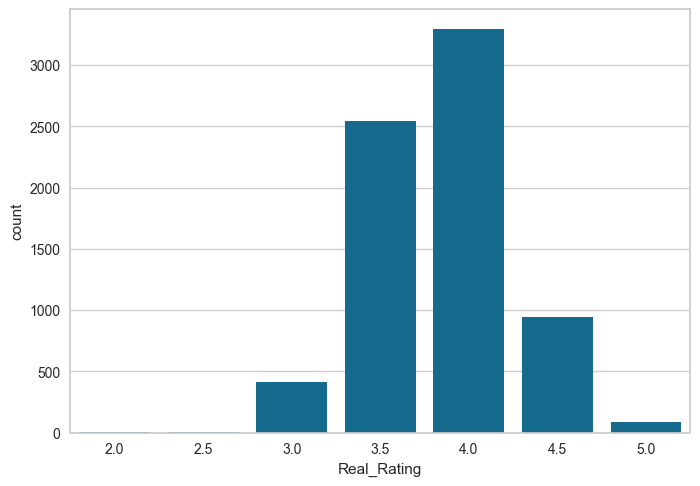

In [26]:
sns.countplot(data=low_error, x='Real_Rating')
plt.ticklabel_format(style='plain', axis='y')
plt.show()


It looks like this model is best at predicting ratings of 4.0. It Is also worth noting that this rating distribution is similar to the total data set.

To get a better idea of the amount of accurate predictions we have, I want to create a subset of the dataframe that only includes the rows where the actual user rating and the predicted user ratings match.

In [27]:
Perfect_KNN=KNN_Predictions.query('Real_Rating == Estimated_Rating')

In [28]:
Perfect_KNN.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 4223 to 37165
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   UserID              12 non-null     int64  
 1   WineID              12 non-null     int64  
 2   Real_Rating         12 non-null     float64
 3   Estimated_Rating    12 non-null     float64
 4   Estimation_Rounded  12 non-null     float64
 5   Error               12 non-null     float64
dtypes: float64(4), int64(2)
memory usage: 672.0 bytes


In [29]:
Perfect_KNN

,UserID,WineID,Real_Rating,Estimated_Rating,Estimation_Rounded,Error
4223,1132942,111415,5.0,5.0,5.0,0.0
9862,1269346,179061,5.0,5.0,5.0,0.0
11182,1129337,174184,5.0,5.0,5.0,0.0
11470,1078952,179043,5.0,5.0,5.0,0.0
12126,1187231,174184,5.0,5.0,5.0,0.0
20323,1016381,179043,5.0,5.0,5.0,0.0
20344,1013202,174184,5.0,5.0,5.0,0.0
23318,1085339,111415,5.0,5.0,5.0,0.0
29097,1214100,174184,5.0,5.0,5.0,0.0
31572,1139787,111415,5.0,5.0,5.0,0.0


From this we can see that only 12 of the estimated ratings for this model are perfect matches to the real ratings. We can also see that all of these predicted ratings are 5.0.

Let’s take a look at our predictions with the SVD model.

In [30]:
SVD_Predictions.head()

,UserID,WineID,Real_Rating,Estimated_Rating,Estimation_Rounded,Error
0,1971360,111475,4.0,4.232196,4.0,0.232196
1,1358888,193487,3.0,3.445211,3.5,0.445211
2,1222064,155623,3.0,3.068288,3.0,0.068288
3,1095942,113730,4.5,4.209202,4.0,0.290798
4,1006401,111434,4.0,4.290544,4.5,0.290544


In [31]:
(SVD_Predictions['Real_Rating'][SVD_Predictions['Error'] == 0].count())/(SVD_Predictions['Real_Rating'].count())*100

0.0

In [32]:
Perfect_SVD=SVD_Predictions.query('Real_Rating == Estimated_Rating')

In [33]:
Perfect_SVD.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   UserID              0 non-null      int64  
 1   WineID              0 non-null      int64  
 2   Real_Rating         0 non-null      float64
 3   Estimated_Rating    0 non-null      float64
 4   Estimation_Rounded  0 non-null      float64
 5   Error               0 non-null      float64
dtypes: float64(4), int64(2)
memory usage: 0.0 bytes


The SVD model predicts 0 accurate ratings in the estimated column. Let’s take a look at how many ratings we get with a low error.

In [34]:
low_error2=SVD_Predictions[SVD_Predictions['Error'] < .1]

In [35]:
low_error2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7078 entries, 2 to 37496
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   UserID              7078 non-null   int64  
 1   WineID              7078 non-null   int64  
 2   Real_Rating         7078 non-null   float64
 3   Estimated_Rating    7078 non-null   float64
 4   Estimation_Rounded  7078 non-null   float64
 5   Error               7078 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 387.1 KB


In [36]:
low_error2.head()

,UserID,WineID,Real_Rating,Estimated_Rating,Estimation_Rounded,Error
2,1222064,155623,3.0,3.068288,3.0,0.068288
5,1215266,111429,4.0,4.082315,4.0,0.082315
7,1064790,113344,4.0,3.970611,4.0,0.029389
10,1387564,167530,3.5,3.523824,3.5,0.023824
12,1765460,111590,4.0,4.037386,4.0,0.037386


The number of predictions in this data subset is 7093. This is similar to but less than the number of low error predictions from the KNN baseline model. Let’s take a look at the distribution of this subset as well.

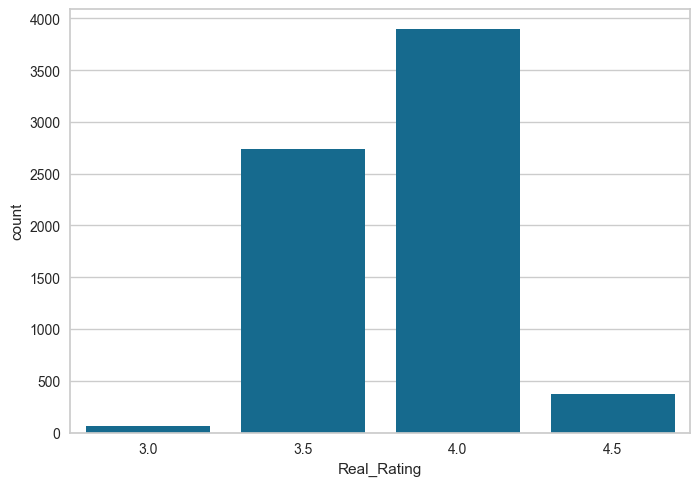

In [37]:
sns.countplot(data=low_error2, x='Real_Rating')
plt.ticklabel_format(style='plain', axis='y')
plt.show()


The rating distribution for this model is very similar to the KNNBaseline model with the top represented rating being 4.0.

### Conclusions

After using each model to create predictions it looks like the KNNBaseline model produces better results than the SVD model. The SVD model predicted zero accurate estimated ratings while the KNN baseline produces a small percentage of accurate predictions of the user ratings. It seems that the KNNBaseline would be the better model to use to increase the chance of predicting ratings more accurately. 